Курсовая работа:

> Предсказание появления аурор



Первая проблема: нужно обработать данные из Excel. Для этого подключаем библиотеку pandas.

In [ ]:
!ls

 auroras_heatmap.html   drive  'new all dates.xlsx'   predictions.csv   sample_data


In [ ]:
#pip install pandas scikit-learn openpyxl
import pandas as pd
import numpy as np

# Загрузили данные из Excel файла
data = pd.read_excel('new all dates.xlsx')

# вывод первых 5 строк данных
print(data.head())

print(data.tail())


        ДАТА  ISN  F107  NSN  NSA  XRBG  XRC  XRM  XRX  XRS   kp 1   kp 2  \
0 2020-01-01    6    72    0    0  A8.0    0    0    0    0  0.333  0.000   
1 2020-01-02   12    72   13   20  A8.3    0    0    0    0  0.000  0.000   
2 2020-01-03   13    71   13   20  A8.6    0    0    0    0  0.667  1.000   
3 2020-01-04   12    72   11   10  A8.5    0    0    0    0  1.667  0.667   
4 2020-01-05   14    72   11   10  A8.5    0    0    0    0  1.667  1.000   

    kp 3   kp 4   kp 5   kp 6   kp 7   kp 8    kp res auror_res  
0  0.000  0.667  0.667  1.333  1.000  0.667  0.583375       NaN  
1  0.333  0.333  0.333  0.667  1.000  1.000  0.458250       NaN  
2  2.667  2.000  1.000  0.667  0.333  1.333  1.208375       NaN  
3  0.667  0.667  1.000  2.000  2.333  2.000  1.375125       NaN  
4  1.667  1.333  2.000  2.000  3.333  2.667  1.958375       NaN  
           ДАТА  ISN  F107  NSN  NSA XRBG  XRC  XRM  XRX  XRS   kp 1   kp 2  \
1456 2023-12-27   79   149   78  520    *    4    0    0    4 

преобразуем столбец с датами в удобный формат для модели. Будем отсчитывать кол-во дней, начиная с 1 января. Например 3 января - это 3, 1 февраля - это 32 и т.д.

In [ ]:
data['ДАТА'] = (data['ДАТА'] - pd.Timestamp("2020-01-01")) // pd.Timedelta('1D')
print(data.head())

   ДАТА  ISN  F107  NSN  NSA  XRBG  XRC  XRM  XRX  XRS   kp 1   kp 2   kp 3  \
0     0    6    72    0    0  A8.0    0    0    0    0  0.333  0.000  0.000   
1     1   12    72   13   20  A8.3    0    0    0    0  0.000  0.000  0.333   
2     2   13    71   13   20  A8.6    0    0    0    0  0.667  1.000  2.667   
3     3   12    72   11   10  A8.5    0    0    0    0  1.667  0.667  0.667   
4     4   14    72   11   10  A8.5    0    0    0    0  1.667  1.000  1.667   

    kp 4   kp 5   kp 6   kp 7   kp 8    kp res auror_res  
0  0.667  0.667  1.333  1.000  0.667  0.583375       NaN  
1  0.333  0.333  0.667  1.000  1.000  0.458250       NaN  
2  2.000  1.000  0.667  0.333  1.333  1.208375       NaN  
3  0.667  1.000  2.000  2.333  2.000  1.375125       NaN  
4  1.333  2.000  2.000  3.333  2.667  1.958375       NaN  


У нас есть столбец XRBG. Там записаны значения уровня фоновой рентгеновской радиации в очень неудобном формате. Например, A8.3. И как это разобрать?
Для начала уберём букву "А", т.к там везде написана эта буква. И расшифруем числа по категориям: А8.3 --> 8.3 --> очень высокий

Разделение по категориям:

[0, 5, 6, 7, 8, 9]  # Определяем границы для категорий

['Очень низкий', 'Низкий', 'Средний', 'Высокий', 'Очень высокий']

От 0 до 5 очень низкий, от 5 до 6 низкий и т.д.

Для корректного обучения модели необходимо почистить данные. В столбце XRBG данные A8.3 или *.

Заменим нечитаемые символы '*' на 0.


In [ ]:
# Заменяем '*' на 0 только в столбце 'XRBG'
data['XRBG'] = data['XRBG'].replace('*', 0)

# Удаляем символ 'A' и преобразуем строки в числа
data['XRBG'] = data['XRBG'].str.replace('A', '').astype(float)


print(data.head()) # первые 5 строк табл
print(data.tail()) # последние 5 строк табл




   ДАТА  ISN  F107  NSN  NSA  XRBG  XRC  XRM  XRX  XRS   kp 1   kp 2   kp 3  \
0     0    6    72    0    0   8.0    0    0    0    0  0.333  0.000  0.000   
1     1   12    72   13   20   8.3    0    0    0    0  0.000  0.000  0.333   
2     2   13    71   13   20   8.6    0    0    0    0  0.667  1.000  2.667   
3     3   12    72   11   10   8.5    0    0    0    0  1.667  0.667  0.667   
4     4   14    72   11   10   8.5    0    0    0    0  1.667  1.000  1.667   

    kp 4   kp 5   kp 6   kp 7   kp 8    kp res auror_res  
0  0.667  0.667  1.333  1.000  0.667  0.583375       NaN  
1  0.333  0.333  0.667  1.000  1.000  0.458250       NaN  
2  2.000  1.000  0.667  0.333  1.333  1.208375       NaN  
3  0.667  1.000  2.000  2.333  2.000  1.375125       NaN  
4  1.333  2.000  2.000  3.333  2.667  1.958375       NaN  
      ДАТА  ISN  F107  NSN  NSA  XRBG  XRC  XRM  XRX  XRS   kp 1   kp 2  \
1456  1456   79   149   78  520   NaN    4    0    0    4  2.000  1.667   
1457  1457   97   147

In [ ]:
# Проверим, остались ли NaN после преобразования
print(data['XRBG'].isna().sum())

1392


Видим, что в столбце XRBG 0 превратилось в NaN. Надо исправить на 0:

In [ ]:
data['XRBG'] = data['XRBG'].fillna(0)
print(data.tail()) # последние 5 строк табл

      ДАТА  ISN  F107  NSN  NSA  XRBG  XRC  XRM  XRX  XRS   kp 1   kp 2  \
1456  1456   79   149   78  520   0.0    4    0    0    4  2.000  1.667   
1457  1457   97   147   83  430   0.0    4    0    0    4  0.000  0.000   
1458  1458   87   143   92  582   0.0   11    0    0   11  1.333  1.000   
1459  1459   71   140   48  470   0.0    9    0    0    9  1.000  2.333   
1460  1460   54   146   55  380   0.0   10    1    1   40  0.000  0.667   

       kp 3   kp 4   kp 5   kp 6   kp 7   kp 8    kp res auror_res  
1456  1.000  1.333  0.333  0.667  0.667  0.333  1.000000       NaN  
1457  0.667  0.333  0.333  0.333  0.000  1.667  0.416625       NaN  
1458  1.333  2.000  1.667  0.667  1.667  2.333  1.500000       NaN  
1459  1.333  0.333  0.667  1.000  1.000  0.000  0.958250       NaN  
1460  0.333  0.333  0.333  0.667  1.000  1.333  0.583250       YES  


In [ ]:
# Определяем границы для категорий
bins = [-1, 5, 6, 7, 8, 10]
labels = ['Очень низкий', 'Низкий', 'Средний', 'Высокий', 'Очень высокий']
# X_train['XRBG_category'] = pd.cut(X_train['XRBG'].str.replace('A', '').astype(float), bins=bins, labels=labels)

# Разбиение на категории без преобразования строк
data['XRBG_category'] = pd.cut(data['XRBG'], bins=bins, labels=labels)


In [ ]:
print(data.head()) # первые 5 строк табл

   ДАТА  ISN  F107  NSN  NSA  XRBG  XRC  XRM  XRX  XRS  ...   kp 2   kp 3  \
0     0    6    72    0    0   8.0    0    0    0    0  ...  0.000  0.000   
1     1   12    72   13   20   8.3    0    0    0    0  ...  0.000  0.333   
2     2   13    71   13   20   8.6    0    0    0    0  ...  1.000  2.667   
3     3   12    72   11   10   8.5    0    0    0    0  ...  0.667  0.667   
4     4   14    72   11   10   8.5    0    0    0    0  ...  1.000  1.667   

    kp 4   kp 5   kp 6   kp 7   kp 8    kp res  auror_res  XRBG_category  
0  0.667  0.667  1.333  1.000  0.667  0.583375        NaN        Высокий  
1  0.333  0.333  0.667  1.000  1.000  0.458250        NaN  Очень высокий  
2  2.000  1.000  0.667  0.333  1.333  1.208375        NaN  Очень высокий  
3  0.667  1.000  2.000  2.333  2.000  1.375125        NaN  Очень высокий  
4  1.333  2.000  2.000  3.333  2.667  1.958375        NaN  Очень высокий  

[5 rows x 21 columns]


In [ ]:
print(data.tail()) # последние 5 строк табл


      ДАТА  ISN  F107  NSN  NSA  XRBG  XRC  XRM  XRX  XRS  ...   kp 2   kp 3  \
1456  1456   79   149   78  520   0.0    4    0    0    4  ...  1.667  1.000   
1457  1457   97   147   83  430   0.0    4    0    0    4  ...  0.000  0.667   
1458  1458   87   143   92  582   0.0   11    0    0   11  ...  1.000  1.333   
1459  1459   71   140   48  470   0.0    9    0    0    9  ...  2.333  1.333   
1460  1460   54   146   55  380   0.0   10    1    1   40  ...  0.667  0.333   

       kp 4   kp 5   kp 6   kp 7   kp 8    kp res  auror_res XRBG_category  
1456  1.333  0.333  0.667  0.667  0.333  1.000000        NaN  Очень низкий  
1457  0.333  0.333  0.333  0.000  1.667  0.416625        NaN  Очень низкий  
1458  2.000  1.667  0.667  1.667  2.333  1.500000        NaN  Очень низкий  
1459  0.333  0.667  1.000  1.000  0.000  0.958250        NaN  Очень низкий  
1460  0.333  0.333  0.667  1.000  1.333  0.583250        YES  Очень низкий  

[5 rows x 21 columns]


Заменим столбец с результатами auror_res: YES на 1, Nan на 0

In [ ]:
data['auror_res'] = data['auror_res'].fillna(0)
data['auror_res'] = data['auror_res'].replace('YES', 1)

print(data.head())

print(data.tail())

   ДАТА  ISN  F107  NSN  NSA  XRBG  XRC  XRM  XRX  XRS  ...   kp 2   kp 3  \
0     0    6    72    0    0   8.0    0    0    0    0  ...  0.000  0.000   
1     1   12    72   13   20   8.3    0    0    0    0  ...  0.000  0.333   
2     2   13    71   13   20   8.6    0    0    0    0  ...  1.000  2.667   
3     3   12    72   11   10   8.5    0    0    0    0  ...  0.667  0.667   
4     4   14    72   11   10   8.5    0    0    0    0  ...  1.000  1.667   

    kp 4   kp 5   kp 6   kp 7   kp 8    kp res  auror_res  XRBG_category  
0  0.667  0.667  1.333  1.000  0.667  0.583375          0        Высокий  
1  0.333  0.333  0.667  1.000  1.000  0.458250          0  Очень высокий  
2  2.000  1.000  0.667  0.333  1.333  1.208375          0  Очень высокий  
3  0.667  1.000  2.000  2.333  2.000  1.375125          0  Очень высокий  
4  1.333  2.000  2.000  3.333  2.667  1.958375          0  Очень высокий  

[5 rows x 21 columns]
      ДАТА  ISN  F107  NSN  NSA  XRBG  XRC  XRM  XRX  XRS  ...  

Разделим данные на Х и У:

In [ ]:
X = data.drop(columns=['auror_res', 'XRBG_category'])  # Все столбцы, кроме 'Aurora' и 'XRBG_category'
y = data['auror_res']  # Столбец с целевой переменной


разделим данные на обучающую и тестовую выборки. 0.2 - это 20 проц тестовая, 80% обучащая

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [ ]:
print(X_train.isna().sum())  # Покажет количество NaN в каждом столбце


ДАТА      0
ISN       0
F107      0
NSN       0
NSA       0
XRBG      0
XRC       0
XRM       0
XRX       0
XRS       0
kp 1      0
kp 2      0
kp 3      0
kp 4      0
kp 5      0
kp 6      0
kp 7      0
kp 8      0
kp res    0
dtype: int64


обучим модель с помощью RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Обучение модели
model = RandomForestClassifier(random_state=42, n_estimators=200)
model.fit(X_train, y_train)


RandomForestClassifier(n_estimators=200, random_state=42)

оцениваем точность модели

In [ ]:
# Оценка модели
accuracy = model.score(X_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')


Test Accuracy: 0.92


In [ ]:
from sklearn.metrics import classification_report

# Получаем предсказания для тестового набора данных
y_pred = model.predict(X_test)

# Выводим отчет о классификации
report = classification_report(y_test, y_pred, target_names=['0', '1'])
print(report)


              precision    recall  f1-score   support

           0       0.94      0.98      0.96       407
           1       0.33      0.16      0.21        32

    accuracy                           0.92       439
   macro avg       0.63      0.57      0.58       439
weighted avg       0.89      0.92      0.90       439



In [ ]:
prediction = model.predict(X_test)
mean_absolute_error(y_test, prediction)

0.07517084282460136

In [ ]:
prediction # предсказанные полярные сияния

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
y_test.values # фактические полярные сияния

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
X_test

,ДАТА,ISN,F107,NSN,NSA,XRBG,XRC,XRM,XRX,XRS,kp 1,kp 2,kp 3,kp 4,kp 5,kp 6,kp 7,kp 8,kp res
1126,1126,76,137,65,360,0.0,7,0,0,7,0.000,2.000,2.667,2.000,1.000,3.333,2.333,1.667,1.875000
231,231,16,71,15,30,0.0,0,0,0,0,2.667,2.333,0.333,0.333,0.333,0.667,0.667,1.000,1.041625
1129,1129,67,135,74,190,0.0,4,0,0,4,2.000,1.667,0.333,0.333,1.667,3.000,2.667,1.667,1.666750
596,596,22,75,25,40,0.0,0,0,0,0,0.000,0.333,0.333,1.333,1.333,1.333,1.333,1.000,0.874750
582,582,24,74,36,30,0.0,0,0,0,0,0.000,0.000,0.000,0.333,0.333,1.000,0.667,0.000,0.291625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1375,1375,126,157,145,490,0.0,9,1,0,19,1.000,1.333,1.000,0.333,0.333,0.667,1.667,1.333,0.958250
1260,1260,114,144,107,690,0.0,9,0,0,9,2.667,0.667,0.333,0.667,0.333,0.667,0.333,0.333,0.750000
1019,1019,62,119,59,110,0.0,3,0,0,3,3.000,1.667,2.333,3.667,4.000,3.000,2.333,3.333,2.916625
28,28,12,74,11,60,8.1,0,0,0,0,3.000,3.333,1.667,1.333,0.333,1.667,1.667,2.000,1.875000


Визуализируем важность признаков, какие из них оказали наибольшее влияние:

In [ ]:
import matplotlib.pyplot as plt

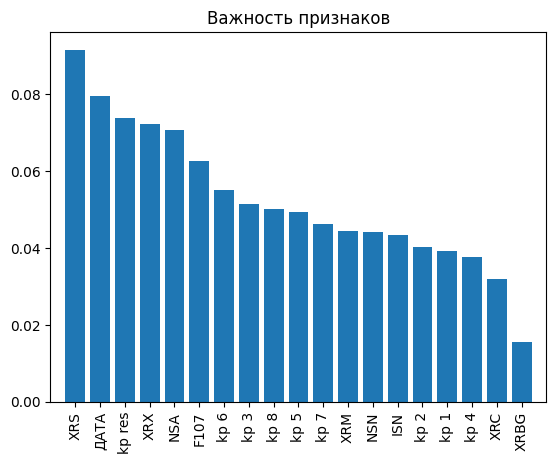

In [ ]:
importances = model.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title('Важность признаков')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), features[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()



Пояснение: Если по оси ординат значение 0.08, это означает, что самый важный признак вносит 8% вклада в принятие решений модели.

In [ ]:
data

,ДАТА,ISN,F107,NSN,NSA,XRBG,XRC,XRM,XRX,XRS,...,kp 2,kp 3,kp 4,kp 5,kp 6,kp 7,kp 8,kp res,auror_res,XRBG_category
0,0,6,72,0,0,8.0,0,0,0,0,...,0.000,0.000,0.667,0.667,1.333,1.000,0.667,0.583375,0,Высокий
1,1,12,72,13,20,8.3,0,0,0,0,...,0.000,0.333,0.333,0.333,0.667,1.000,1.000,0.458250,0,Очень высокий
2,2,13,71,13,20,8.6,0,0,0,0,...,1.000,2.667,2.000,1.000,0.667,0.333,1.333,1.208375,0,Очень высокий
3,3,12,72,11,10,8.5,0,0,0,0,...,0.667,0.667,0.667,1.000,2.000,2.333,2.000,1.375125,0,Очень высокий
4,4,14,72,11,10,8.5,0,0,0,0,...,1.000,1.667,1.333,2.000,2.000,3.333,2.667,1.958375,0,Очень высокий
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,1456,79,149,78,520,0.0,4,0,0,4,...,1.667,1.000,1.333,0.333,0.667,0.667,0.333,1.000000,0,Очень низкий
1457,1457,97,147,83,430,0.0,4,0,0,4,...,0.000,0.667,0.333,0.333,0.333,0.000,1.667,0.416625,0,Очень низкий
1458,1458,87,143,92,582,0.0,11,0,0,11,...,1.000,1.333,2.000,1.667,0.667,1.667,2.333,1.500000,0,Очень низкий
1459,1459,71,140,48,470,0.0,9,0,0,9,...,2.333,1.333,0.333,0.667,1.000,1.000,0.000,0.958250,0,Очень низкий


Теперь сравним насколько точно модель предсказала появление аурор по месяцам по сравнению с фактическим кол-вом:

In [ ]:
data = data[data['ДАТА'].isin(X_test['ДАТА'].values)]

In [ ]:
data.shape, X_test.shape

((439, 21), (439, 19))

<ipython-input-219-cda2c8bfc26e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Дата'] = pd.Timestamp("2020-01-01") + pd.to_timedelta(data['ДАТА'], unit='D')
<ipython-input-219-cda2c8bfc26e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Месяц'] = data['Дата'].dt.month
<ipython-input-219-cda2c8bfc26e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

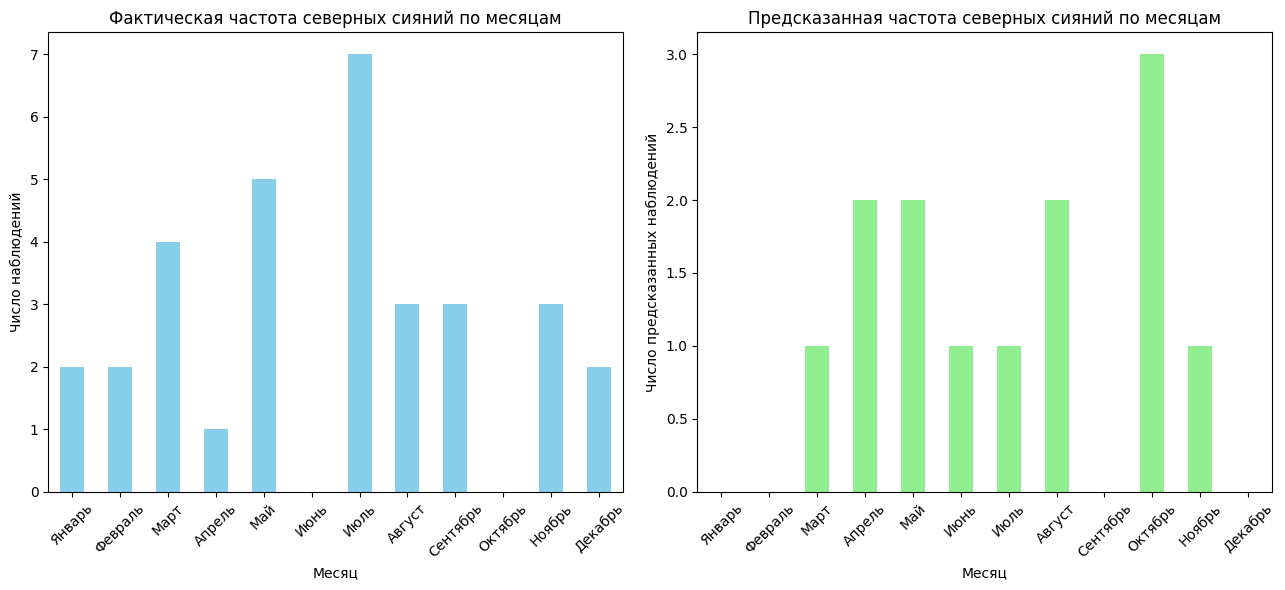

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Преобразуем количество дней обратно в формат даты
data['Дата'] = pd.Timestamp("2020-01-01") + pd.to_timedelta(data['ДАТА'], unit='D')

# Извлекаем месяц и сезон из вновь созданного столбца
data['Месяц'] = data['Дата'].dt.month
data['Сезон'] = data['Дата'].dt.month % 12 // 3 + 1
data['Сезон'] = data['Сезон'].map({1: 'Весна', 2: 'Лето', 3: 'Осень', 4: 'Зима'})

# Получаем предсказания модели
data['predicted_auror_res'] = model.predict(X_test)

# Сохраняем предсказания в отдельный файл для последующего использования
data.to_csv('predictions.csv', index=False)
loaded_data = pd.read_csv('predictions.csv')


# Подсчет фактического количества северных сияний по месяцам
actual_monthly_counts = data.groupby('Месяц')['auror_res'].sum()


# Подсчет предсказанного количества северных сияний по месяцам
predicted_monthly_counts = data.groupby('Месяц')['predicted_auror_res'].sum()

# Построение графиков
plt.figure(figsize=(13, 6))

# Гистограмма фактического распределения
plt.subplot(1, 2, 1)
actual_monthly_counts.plot(kind='bar', color='skyblue')
plt.title('Фактическая частота северных сияний по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Число наблюдений')
plt.xticks(ticks=range(0, 12), labels=['Январь', 'Февраль', 'Март', 'Апрель', 'Май', 'Июнь', 'Июль', 'Август', 'Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь'], rotation=45)

# Гистограмма предсказанного распределения
plt.subplot(1, 2, 2)
predicted_monthly_counts.plot(kind='bar', color='lightgreen')
plt.title('Предсказанная частота северных сияний по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Число предсказанных наблюдений')
plt.xticks(ticks=range(0, 12), labels=['Январь', 'Февраль', 'Март', 'Апрель', 'Май', 'Июнь', 'Июль', 'Август', 'Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь'], rotation=45)

# Показать оба графика
plt.tight_layout()
plt.show()


In [ ]:
# Чтение файла
pred_aur = pd.read_csv('predictions.csv')

# Просмотр первых нескольких строк
print(pred_aur.head())

# Просмотр общей информации о DataFrame
print(pred_aur.info())

   ДАТА  ISN  F107  NSN  NSA  XRBG  XRC  XRM  XRX  XRS  ...   kp 6   kp 7  \
0     1   12    72   13   20   8.3    0    0    0    0  ...  0.667  1.000   
1     4   14    72   11   10   8.5    0    0    0    0  ...  2.000  3.333   
2     9    4    73   11   10   9.0    0    0    0    0  ...  1.667  1.333   
3    15    0    72    0    0   8.0    0    0    0    0  ...  0.667  0.333   
4    16    0    70    0    0   8.0    0    0    0    0  ...  1.333  1.000   

    kp 8    kp res  auror_res  XRBG_category        Дата  Месяц  Сезон  \
0  1.000  0.458250          0  Очень высокий  2020-01-02      1  Весна   
1  2.667  1.958375          0  Очень высокий  2020-01-05      1  Весна   
2  0.667  1.458375          0  Очень высокий  2020-01-10      1  Весна   
3  0.333  1.000000          0        Высокий  2020-01-16      1  Весна   
4  0.333  0.541500          0        Высокий  2020-01-17      1  Весна   

   predicted_auror_res  
0                    0  
1                    0  
2                

In [ ]:
# Выведем в числах для сравнения фактические и предсказанные значения
comparison_df = pd.DataFrame({
    'Фактические ауроры': actual_monthly_counts,
    'Предсказанные ауроры': predicted_monthly_counts
})

# Выводим таблицу для сравнения
print(comparison_df)


       Фактические ауроры  Предсказанные ауроры
Месяц                                          
1                       2                     0
2                       2                     0
3                       4                     1
4                       1                     2
5                       5                     2
6                       0                     1
7                       7                     1
8                       3                     2
9                       3                     0
10                      0                     3
11                      3                     1
12                      2                     0


In [ ]:
# # Проверим, что данные числовые
# comparison_df['Фактические ауроры'] = pd.to_numeric(comparison_df['Фактические ауроры'], errors='coerce')
# comparison_df['Предсказанные ауроры'] = pd.to_numeric(comparison_df['Предсказанные ауроры'], errors='coerce')

# # Проверим, есть ли NaN и если есть, удалим
# comparison_df = comparison_df.dropna()

# # Рассчитываем метрики
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Рассчитываем RMSE
rmse = np.sqrt(mean_squared_error(y_test, prediction))

# Рассчитываем MAE
mae = mean_absolute_error(y_test, prediction)


# Выводим результаты
print(f"Среднеквадратичная ошибка (RMSE): {rmse}")
print(f"Средняя абсолютная ошибка (MAE): {mae}")


Среднеквадратичная ошибка (RMSE): 0.274173016222606
Средняя абсолютная ошибка (MAE): 0.07517084282460136


Попробуем использовать 3D визуализацию(Folium). Отметим на карте мира места, для которых мы составляли статистику появления аурор: Норвегия (Тромсё), Якутия (Оймякон), и Мурманск.

In [ ]:
import folium

# Создаем карту, центрированную на северное полушарие
aurora_map = folium.Map(location=[65, 30], zoom_start=4)

# Добавляем маркеры для предсказанных сияний
folium.Marker([69.6492, 18.9560], popup='Тромсё, Норвегия: предсказано северное сияние').add_to(aurora_map)
folium.Marker([63.4641, 142.7737], popup='Оймякон, Якутия: предсказано северное сияние').add_to(aurora_map)
folium.Marker([68.9730, 33.0868], popup='Мурманск, Россия: предсказано северное сияние').add_to(aurora_map)

# Отображаем карту
aurora_map



### **Пробуем обучить модель, используя градиентный бустинг.**

In [ ]:
# подключаем необходимые библиотеки
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [ ]:
# Инициализация модели градиентного бустинга
model = GradientBoostingClassifier(random_state=42)

# Обучение модели
model.fit(X_train, y_train,)


GradientBoostingClassifier(random_state=42)

Зададим score таким образом. В зависимости от того, какое значение score мы выберем, будет изменяться precision и recall. Чем выше score, тем выше precision и ниже recall. То есть более высокая точность/вероятность того, что я предскажу появление аурор, исходя из обучающих данных. Но тем меньше точность/вероятность, что если было сияние, то я его предскажу, что оно было.

А если уменьшаем score, то наоборот precision ниже, а recall выше.

Пояснить код:

score - бинарный вектор предсказаний модели. True означает, что модель предсказывает "да, будет полярное сияние", а False — "нет, не будет".

precision (Точность) - доля правильных предсказаний класса "да" среди всех предсказанных "да". Выражается как TP / (TP + FP), где TP — количество истинно положительных результатов, а FP — количество ложно положительных.

recall (Полнота) - доля правильных предсказаний класса "да" среди всех истинных "да". Выражается как TP / (TP + FN), где FN — количество ложно отрицательных.

f1-score - среднее гармоническое между precision и recall. Эта метрика полезна, когда нужно сбалансировать обе метрики. Вычисляется как 2 * (precision * recall) / (precision + recall).

support - количество истинных примеров для каждого класса в y_test.

In [ ]:
score = model.predict_proba(X_test)[:, 1]
score = score >= 0.8
# Оценка точности модели
accuracy = accuracy_score(y_test, score)
print(f'Test Accuracy: {accuracy:.2f}')

# Дополнительные метрики
print(classification_report(y_test, score))

# Матрица ошибок
print(confusion_matrix(y_test, score))

Test Accuracy: 0.93
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       407
           1       0.62      0.16      0.25        32

    accuracy                           0.93       439
   macro avg       0.78      0.57      0.61       439
weighted avg       0.91      0.93      0.91       439

[[404   3]
 [ 27   5]]


Визуализируем матрицу ошибок:

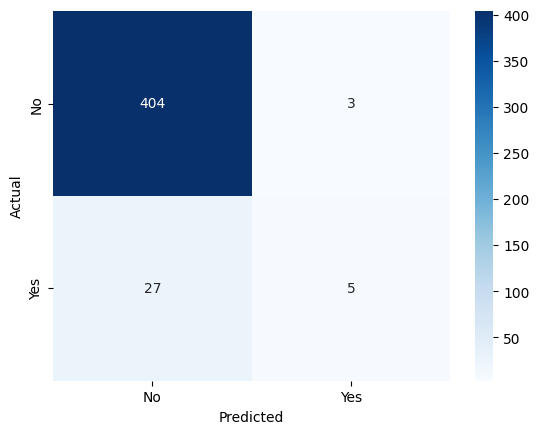

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Вычисление матрицы ошибок
cm = confusion_matrix(y_test, score)

# Визуализация
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


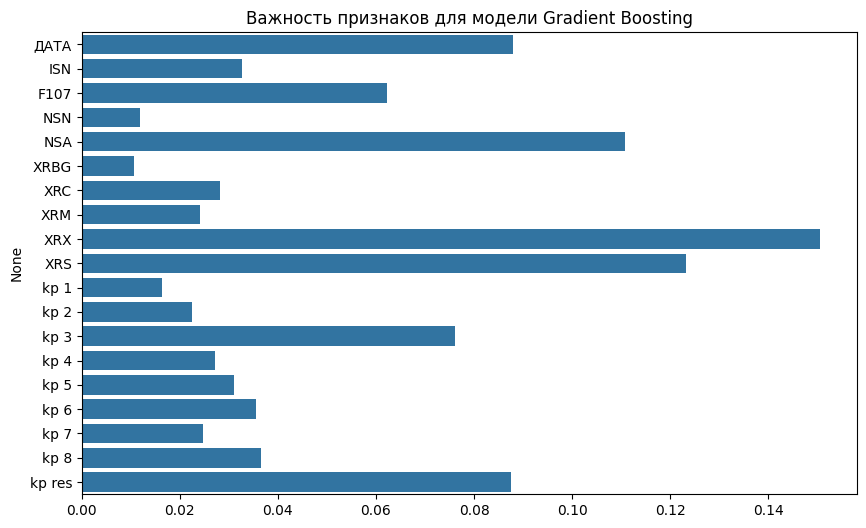

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Важность признаков
feature_importances = model.feature_importances_

# Визуализация
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=X.columns)
plt.title('Важность признаков для модели Gradient Boosting')
plt.show()


Пробуем улучшить модель, прописываем вручную характеристики:


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

model_new = GradientBoostingClassifier(
    n_estimators=200, # увеличиили n_estimators до 200. По умолчанию было 100. Чем большедеревьев, тем лучше модель моет обучаться(но дольше будет работать).
    learning_rate=0.05, # уменьшили скорость обучния до 0.05. По умолчанию 1. Меньшие значения могут повысить качество модели(но потребуют больше деревьев)
    max_depth=4, # увеличим макс глубину. По умолчанию было 3. Чем глубже дерево, тем более сложные паттерны оно сможет улавливать(но это может привести к переобучению).
    subsample=0.8, # долю обучаемых данных, которую используем для каждого дерева уменьшим до 0.8( по умолчанию 1.0)
    min_samples_split=10, # минимальное количество образцов, необходимых для разбиения узла. Этот параметр поможет избежать переобучения.
    min_samples_leaf=5, # минимальное количество образцов в листе. Этот параметр поможет избежать переобучения.
    random_state=42 #
)

Сравнение насколько улучшилась или ухудшилась модель при попытке прописать вручную характеристки для град. бустинга:

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Сохранение метрик для старой модели
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    score = model.predict_proba(X_test)[:, 1]
    score = score >= 0.8  # порог 0.8
    accuracy = accuracy_score(y_test, score)
    print(f'Test Accuracy: {accuracy:.2f}')
    print(classification_report(y_test, score))
    print('Матрица ошибок:')
    print(confusion_matrix(y_test, score))
    return accuracy

# Инициализация старой модели
model_old = GradientBoostingClassifier(random_state=42)

print("Результаты старой модели:")
accuracy_old = evaluate_model(model_old, X_train, X_test, y_train, y_test)

# Инициализация модернизированной модели
model_new = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)

print("\nРезультаты модернизированной модели:")
accuracy_new = evaluate_model(model_new, X_train, X_test, y_train, y_test)

# Сравнение точности
print(f"\nИзменение точности: {accuracy_new - accuracy_old:.2f}")


Результаты старой модели:
Test Accuracy: 0.93
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       407
           1       0.62      0.16      0.25        32

    accuracy                           0.93       439
   macro avg       0.78      0.57      0.61       439
weighted avg       0.91      0.93      0.91       439

Матрица ошибок:
[[404   3]
 [ 27   5]]

Результаты модернизированной модели:
Test Accuracy: 0.93
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       407
           1       0.57      0.12      0.21        32

    accuracy                           0.93       439
   macro avg       0.75      0.56      0.58       439
weighted avg       0.91      0.93      0.91       439

Матрица ошибок:
[[404   3]
 [ 28   4]]

Изменение точности: -0.00


Визуализируем:


Матрица ошибок для старой модели:


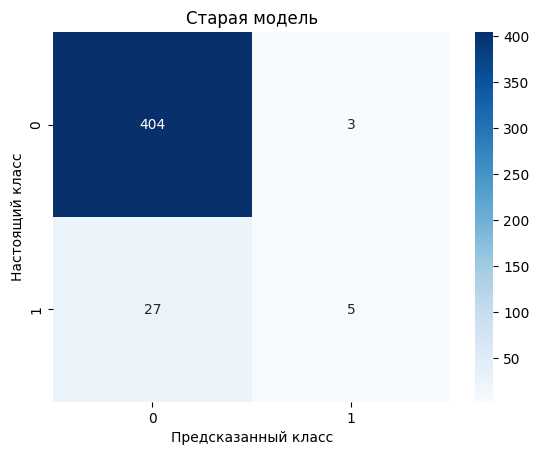


Матрица ошибок для модернизированной модели:


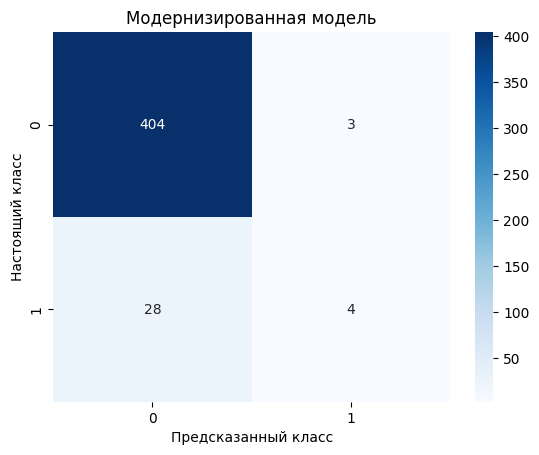

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Матрица ошибок для визуализации
def plot_confusion_matrix(model, X_test, y_test, title):
    score = model.predict_proba(X_test)[:, 1]
    score = score >= 0.8  # порог 0.8
    cm = confusion_matrix(y_test, score)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Предсказанный класс')
    plt.ylabel('Настоящий класс')
    plt.show()

# Визуализация матриц ошибок для двух моделей
print("\nМатрица ошибок для старой модели:")
plot_confusion_matrix(model_old, X_test, y_test, 'Старая модель')

print("\nМатрица ошибок для модернизированной модели:")
plot_confusion_matrix(model_new, X_test, y_test, 'Модернизированная модель')


Не особо что-то улучшилось. Жаль.
Попробуем по-другому улучшить. Зададим accuracy_score по-другому:

Другой способ задания accuracy_score




In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Предсказания вероятностей
y_prob = model.predict_proba(X_test)[:, 1]

# Изменение порога классификации (например, 0.7)
y_pred = (y_prob >= 0.7).astype(int)

# Оценка метрик
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_prob)

print(f"Точность (Accuracy): {accuracy:.2f}")
print(f"Precision (Точность): {precision:.2f}")
print(f"Recall (Полнота): {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"AUC-ROC: {auc_roc:.2f}")


Точность (Accuracy): 0.93
Precision (Точность): 0.50
Recall (Полнота): 0.16
F1-Score: 0.24
AUC-ROC: 0.83


# Логистическая регрессия

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


# Создаем и обучаем модель логистической регрессии
model = LogisticRegression()
model.fit(X_train, y_train)

# Делаем предсказания на тестовой выборке
y_pred = model.predict(X_test)

# Оценка модели
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')
print('Confusion Matrix:')
print(conf_matrix)


Accuracy: 0.91
Precision: 0.23
Recall: 0.09
F1-score: 0.13
Confusion Matrix:
[[397  10]
 [ 29   3]]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
